In [1]:
import ruamel.yaml as yaml
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import matplotlib
from gta_math import construct_proj_matrix

In [2]:
def isempty(a):
    try:
        return 0 in np.asarray(a).shape
    except AttributeError:
        return False

def readVariable(data=None, name=None, M=None, N=None):
    if name not in data:
        return []

    if M != 1 or N != 1:
        values = np.array(data[name].split(), dtype=float)
        values = values.reshape(M, N)
        return values
    else:
        return data[name]

def load_calibration_rigid(filename=None):
    # open file
    with open(filename, 'r') as stream:
        try:
            data = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            return {}

    # read calibration
    R = readVariable(data, 'R', 3, 3)
    T = readVariable(data, 'T', 3, 1)
    Tr = np.concatenate((np.concatenate((R, T), axis=1), np.array([0, 0, 0, 1]).reshape(1, 4)), axis=0)
    return Tr

def load_calibration_cam_to_cam(filename):
    # open file
    with open(filename, 'r') as stream:
        import ruamel.yaml as yaml
        try:
            data = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            return {}

    calib = {'cornerdist': readVariable(data, 'corner_dist', 1, 1), 
             'S': np.zeros((4, 1, 2)),
             'K': np.zeros((4, 3, 3)),
             'D': np.zeros((4, 1, 5)),
             'R': np.zeros((4, 3, 3)),
             'T': np.zeros((4, 3, 1)),
             'S_rect': np.zeros((4, 1, 2)),
             'R_rect': np.zeros((4, 3, 3)),
             'P_rect': np.zeros((4, 3, 4))
             }

    # read corner distance
    # /opt/project/devkit/matlab/load_calibration_cam_to_cam.m:12
    # read all cameras (maximum: 100)

    for cam in np.array(range(4)).reshape(-1):
        # read variables
        S_ = readVariable(data, 'S_{:02d}'.format(cam), 1, 2)
        K_ = readVariable(data, 'K_{:02d}'.format(cam), 3, 3)
        D_ = readVariable(data, 'D_{:02d}'.format(cam), 1, 5)
        R_ = readVariable(data, 'R_{:02d}'.format(cam), 3, 3)
        T_ = readVariable(data, 'T_{:02d}'.format(cam), 3, 1)
        S_rect_ = readVariable(data, 'S_rect_{:02d}'.format(cam), 1, 2)
        R_rect_ = readVariable(data, 'R_rect_{:02d}'.format(cam), 3, 3)
        P_rect_ = readVariable(data, 'P_rect_{:02d}'.format(cam), 3, 4)
        if isempty(S_) or isempty(K_) or isempty(D_) or isempty(R_) or isempty(T_):
            break
        # write calibration
        calib['S'][cam] = S_
        calib['K'][cam] = K_
        calib['D'][cam] = D_
        calib['R'][cam] = R_
        calib['T'][cam] = T_

        if (not isempty(S_rect_)) and (not isempty(R_rect_)) and (not isempty(P_rect_)):
            calib['S_rect'][cam] = S_rect_
            calib['R_rect'][cam] = R_rect_
            calib['P_rect'][cam] = P_rect_

    return calib

def loadFromFile(fname, columns, dtype):
    with open(fname, 'rb') as f:
        result = np.fromfile(f, dtype).reshape((-1, columns))
    return result

def project(p_in=None, T=None):
    # do transformation in homogenuous coordinates
    if np.size(p_in, 1) < 4:
        p2_in = np.zeros((len(p_in), 4))
        p2_in[:, 0:3] = np.copy(p_in)
        p2_in[:, 3] = 1
    else:
        p2_in = p_in

    p_out = p2_in @ T.T
    # normalize homogeneous coordinates:
    p_out /= p_out[:, 2][:, None]
    return p_out


In [3]:
velo_to_cam = load_calibration_rigid('kitti-calibration-example/calib_velo_to_cam.txt')

In [4]:
velo_to_cam

array([[  7.53374500e-03,  -9.99971400e-01,  -6.16602000e-04,
         -4.06976600e-03],
       [  1.48024900e-02,   7.28073300e-04,  -9.99890200e-01,
         -7.63161800e-02],
       [  9.99862100e-01,   7.52379000e-03,   1.48075500e-02,
         -2.71780600e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [5]:
calib = load_calibration_cam_to_cam('kitti-calibration-example/calib_cam_to_cam.txt')

In [6]:
calib

{'D': array([[[-0.3728755 ,  0.2037299 ,  0.00221903,  0.00138371, -0.07233722]],
 
        [[-0.3644661 ,  0.1790019 ,  0.00114811, -0.00062986, -0.05314062]],
 
        [[-0.3691481 ,  0.1968681 ,  0.00135347,  0.00056776, -0.06770705]],
 
        [[-0.3639558 ,  0.1788651 ,  0.00060297, -0.00039224, -0.0538246 ]]]),
 'K': array([[[ 984.2439,    0.    ,  690.    ],
         [   0.    ,  980.8141,  233.1966],
         [   0.    ,    0.    ,    1.    ]],
 
        [[ 989.5267,    0.    ,  702.    ],
         [   0.    ,  987.8386,  245.559 ],
         [   0.    ,    0.    ,    1.    ]],
 
        [[ 959.791 ,    0.    ,  696.0217],
         [   0.    ,  956.9251,  224.1806],
         [   0.    ,    0.    ,    1.    ]],
 
        [[ 903.7596,    0.    ,  695.7519],
         [   0.    ,  901.9653,  224.2509],
         [   0.    ,    0.    ,    1.    ]]]),
 'P_rect': array([[[  7.21537700e+02,   0.00000000e+00,   6.09559300e+02,
            0.00000000e+00],
         [  0.00000000e+00,   7

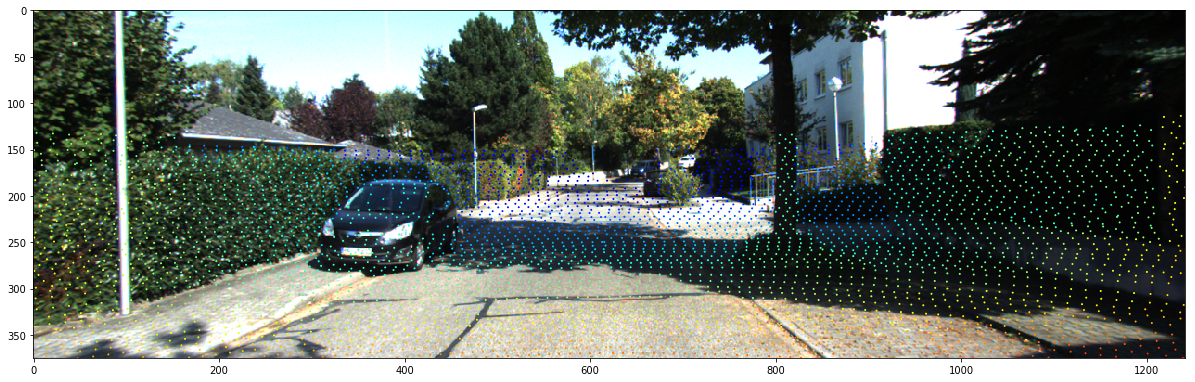

In [7]:
# just trying some visualization to check if I have it correctly
cam = 2
frame = 1

R_cam_to_rect = np.eye(4)
R_cam_to_rect[0:3, 0:3] = calib['R_rect'][0]
P_velo_to_img = (calib['P_rect'][cam] @ R_cam_to_rect) @ velo_to_cam

base_dir = 'kitti-data-example'
img = mpimg.imread('{:s}/image_{:02d}/data/{:010d}.png'.format(base_dir, cam, frame))
fig = plt.figure(figsize=(16, 10))
plt.axes([0, 0, 1, 1])
fname = '{:s}/velodyne_points/data/{:010d}.bin'.format(base_dir, frame)
velo = loadFromFile(fname, 4, np.float32)
# keep only every 5-th point for visualization
velo = velo[0::5, :]
# remove all points behind image plane (approximation)
velo = velo[velo[:, 0] >= 5, :]

# project to image plane (exclude luminance)
velo_img = project(velo[:, 0:3], P_velo_to_img)
# plot points
cols = matplotlib.cm.jet(np.arange(256))  # jet is colormap, represented by lookup table

col_indices = np.round(256 * 5 / velo[:, 0]).astype(int) - 1
plt.scatter(x=velo_img[:, 0], y=velo_img[:, 1], c=cols[col_indices, 0:3], marker='o', s=1)
plt.imshow(img)
plt.show()

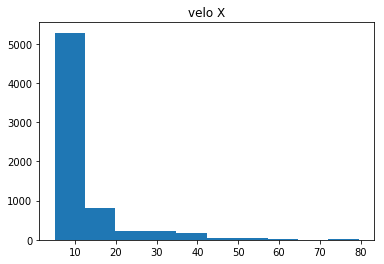

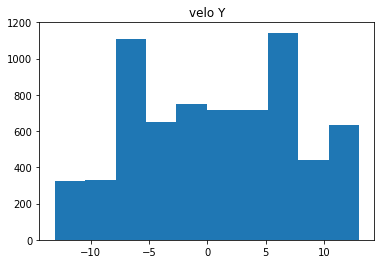

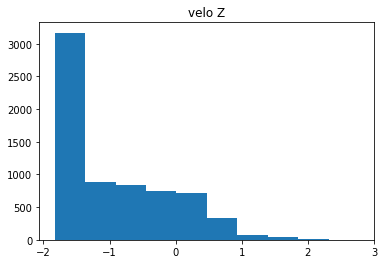

In [8]:
plt.title('velo X')
plt.hist(velo[:, 0])
plt.show()
plt.title('velo Y')
plt.hist(velo[:, 1])
plt.show()
plt.title('velo Z')
plt.hist(velo[:, 2])
plt.show()


In [9]:
T = P_velo_to_img
p_in = velo[:, 0:3]
if p_in.shape[1] < 4:
    p2_in = np.zeros((len(p_in), 4))
    p2_in[:, 0:3] = np.copy(p_in)
    p2_in[:, 3] = 1
else:
    p2_in = p_in

p_out = p2_in @ T.T
p_out /= p_out[:, 2]

ValueError: operands could not be broadcast together with shapes (6818,3) (6818,) (6818,3) 

In [10]:
p_out.shape

(6818, 3)

In [11]:
p_in.shape

(6818, 3)

In [12]:
T

array([[  6.09695409e+02,  -7.21421597e+02,  -1.25125855e+00,
         -1.23041806e+02],
       [  1.80384202e+02,   7.64479802e+00,  -7.19651474e+02,
         -1.01016688e+02],
       [  9.99945389e-01,   1.24365378e-04,   1.04513030e-02,
         -2.69386912e-01]])

In [13]:
R_cam_to_rect

array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
       [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
       [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
calib['P_rect'][0]

array([[ 721.5377,    0.    ,  609.5593,    0.    ],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]])

In [19]:
calib['P_rect'][1]

array([[ 721.5377,    0.    ,  609.5593, -387.5744],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]])

In [16]:
calib['P_rect'][2]

array([[  7.21537700e+02,   0.00000000e+00,   6.09559300e+02,
          4.48572800e+01],
       [  0.00000000e+00,   7.21537700e+02,   1.72854000e+02,
          2.16379100e-01],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.74588400e-03]])

In [17]:
calib['P_rect'][3]

array([[  7.21537700e+02,   0.00000000e+00,   6.09559300e+02,
         -3.39524200e+02],
       [  0.00000000e+00,   7.21537700e+02,   1.72854000e+02,
          2.19993600e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.72990500e-03]])

In [15]:
c_u = calib['P_rect'][cam][0,2]
c_v = calib['P_rect'][cam][1,2]
c_u, c_v

(609.55930000000001, 172.85400000000001)

In [53]:
img.shape

(375, 1242, 3)

In [58]:
np.linalg.det(velo_to_cam[0:3, 0:3])

1.0000000420780264

In [72]:
view_to_image = (calib['P_rect'][cam] @ R_cam_to_rect)
# since all my calculations are for ndc, thus [-1,1] in x and y, I will do transfer it from image to ndc
H = img.shape[0]
W = img.shape[1]
view_to_ndc = np.array([[1/H, 0, 0], [0, 1/W, 0], [0, 0, 1]]) @ view_to_image


In [73]:
view_to_ndc

array([[  1.93598685e+00,   2.60023507e-02,   1.61110647e+00,
          1.19619413e-01],
       [ -4.70360127e-03,   5.81520223e-01,   1.36683214e-01,
          1.74218277e-04],
       [  7.40252700e-03,   4.35161400e-03,   9.99963100e-01,
          2.74588400e-03]])

#### fov to matrix is following

$ x_{00} = \frac{H}{tan(\frac{radians(vfov)}{2}) \cdot W} $

$ x_{11} = \frac{1}{tan(\frac{radians(vfov)}{2})} $

$ x_{00} = \frac{1}{tan(\frac{radians(hfov)}{2})} $


#### matrix to fov is following

$ vfov = degrees(atan2(\frac{H}{x_{00} \cdot W}) \cdot 2) $

$ vfov = degrees(atan2(\frac{1}{x_{11}}) \cdot 2) $

$ hfov = degrees(atan2(\frac{1}{x_{00}}) \cdot 2) $


In [74]:
x_11 = view_to_ndc[1, 1]
vfov = np.degrees(np.arctan2(1, x_11) * 2)

In [75]:
vfov

119.64226598076772

In [76]:
x_00 = view_to_ndc[0, 0]
hfov = np.degrees(np.arctan2(1, x_00) * 2)

In [77]:
hfov

54.635640888927405

In [79]:
print('ratio is:', W/H)

ratio is: 3.312


In [81]:
view_to_ndc

array([[  1.93598685e+00,   2.60023507e-02,   1.61110647e+00,
          1.19619413e-01],
       [ -4.70360127e-03,   5.81520223e-01,   1.36683214e-01,
          1.74218277e-04],
       [  7.40252700e-03,   4.35161400e-03,   9.99963100e-01,
          2.74588400e-03]])

In [82]:
construct_proj_matrix(H, W, fov=54, near_clip=1.5)

array([[  5.92575636e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.96261051e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.49965283e-04,
          1.50022495e+00],
       [  0.00000000e+00,   0.00000000e+00,  -1.00000000e+00,
          0.00000000e+00]])

In [83]:
# possible ratios on GTA:
ratios = [3/2, 4/3, 5/3, 5/4, 16/9, 16/10]
ratios

[1.5, 1.3333333333333333, 1.6666666666666667, 1.25, 1.7777777777777777, 1.6]

In [85]:
real_ratio = W/H
real_ratio

3.312

In [91]:
def vertical_to_horizontal_fov(H, W, vfov):
    matrix = construct_proj_matrix(H, W, vfov, near_clip=1.5)
    return np.degrees(np.arctan2(1, matrix[0, 0]) * 2)

In [95]:
vertical_to_horizontal_fov(9, 16, 90)

121.28449291441746